In [1]:
from autoML import AutoML
from autosklearn.regression import AutoSklearnRegressor
import pandas as pd
import sklearn as sk
import numpy as np

## Loading the data

In [2]:
data = pd.read_csv("datasets/Fish.csv")
print(data.head())
print("Data shape:", data.shape)

  Species  Weight  Length1  Length2  Length3   Height   Width
0   Bream   242.0     23.2     25.4     30.0  11.5200  4.0200
1   Bream   290.0     24.0     26.3     31.2  12.4800  4.3056
2   Bream   340.0     23.9     26.5     31.1  12.3778  4.6961
3   Bream   363.0     26.3     29.0     33.5  12.7300  4.4555
4   Bream   430.0     26.5     29.0     34.0  12.4440  5.1340
Data shape: (159, 7)


## Split into test and training set

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)

train.shape, test.shape

((127, 7), (32, 7))

## Get knowledge over dataset

In [4]:
train.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
50,Roach,200.0,22.1,23.5,26.8,7.3968,4.1272
129,Pike,300.0,31.7,34.0,37.8,5.7078,4.1580
17,Bream,700.0,30.4,33.0,38.5,14.9380,5.1975
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
42,Roach,120.0,19.4,21.0,23.7,6.1146,3.2943


The dataset has 7 attributes (incl. the target attribute *weight*). The attributes *Length1*, *Length2*, *Length3*, *Height* and *Width* are numerical. The attribute *Species* is nominal.

In [5]:
train.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,411.747244,26.625197,28.812598,31.623622,8.957669,4.491662
std,368.393646,10.096699,10.801558,11.657163,4.164525,1.710210
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,127.500000,19.600000,21.400000,23.500000,6.031600,3.466250
50%,290.000000,25.400000,27.500000,30.800000,7.680000,4.335000
75%,667.500000,33.200000,36.000000,39.550000,12.365900,5.658300
max,1650.000000,59.000000,63.400000,68.000000,18.754200,8.142000


In [6]:
set(train["Species"])

{'Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'}

<AxesSubplot:ylabel='Species'>

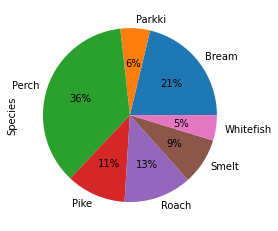

In [7]:
train.groupby("Species").size().plot.pie(ylabel="Species", autopct=lambda val: "{:0.0f}%".format(val))

<AxesSubplot:>

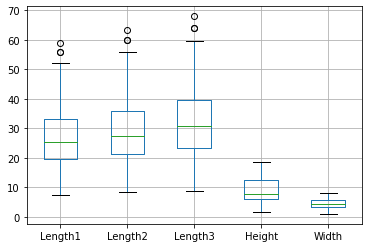

In [8]:
train.drop("Weight", axis=1).boxplot()

## Initialize all regressors

In [9]:
class DummyRegressor():
    def fit(self, X_train, y_train):
        self.range = min(y_train), max(y_train)
    
    def predict(self, X_test):
        return np.random.uniform(self.range[0], self.range[1], [len(X_test)])
    
    def get_params(self, deep=True):
        return {}      

regressors = {
    "dummy": DummyRegressor(),
    "decisionTree": sk.tree.DecisionTreeRegressor(),
    "linearRegression": sk.linear_model.LinearRegression(),
    "randomForestRegressor": sk.ensemble.RandomForestRegressor(),
    "auto-sklearn" : AutoSklearnRegressor(
        time_left_for_this_task = 60,
        per_run_time_limit = 10,
        n_jobs=-1
    ),
    # our regressors
    "autoML": AutoML(fitting_time=60, n_jobs=-1),
}

## Check training performance

In [10]:
from sklearn.metrics import make_scorer

def relative_squared_error(y_pred, y_test):
    avg = np.average(y_test)
    error = y_pred-y_test
    mean_error = -(y_test-avg)
    return np.sum(error**2)/np.sum(mean_error**2)

def correlation_coefficient(y_pred, y_test):
    return np.corrcoef(np.array([y_pred, y_test]))[0][1]

def check_stats(predictor, X, y, name):
    
    scoring = {
        "MSE": make_scorer(sk.metrics.mean_absolute_error),
        "RSE": make_scorer(relative_squared_error),
        "CorrCoef": make_scorer(correlation_coefficient)
    }

    result = sk.model_selection.cross_validate(predictor, X, y, scoring=scoring)

    fit_time = np.mean(result["fit_time"])
    score_time = np.mean(result["score_time"])
    mse = np.mean(result["test_MSE"])
    rse = np.mean(result["test_RSE"])
    corr = np.mean(result["test_CorrCoef"])

    return name, mse, rse, corr, fit_time, score_time

In [11]:
def get_performance(regressors, X, y):
    # check stats of all regressors
    columns = ["Name", "MAE", "RSE", "Corr", "Fit time", "Score time"]
    rows = []
    for regressor_name in regressors:
        stats = check_stats(regressors[regressor_name], X, y, regressor_name)
        rows.append(stats)
    stats = pd.DataFrame(rows, columns=columns)
    return stats

### Preprocessing - Removing "Species"

In [12]:
X_rem = train.drop(["Weight", "Species"], axis=1)
y_rem = train["Weight"]

stats_rem = get_performance(regressors, X_rem, y_rem)
stats_rem

/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  war

,Name,MAE,RSE,Corr,Fit time,Score time
0,dummy,618.701170,2.977609,-0.201326,0.000491,0.008271
1,decisionTree,57.313415,0.073373,0.969273,0.003202,0.002256
2,linearRegression,97.151837,0.150066,0.939788,0.030207,0.001472
3,randomForestRegressor,45.371539,0.048421,0.982371,0.084885,0.007851
4,auto-sklearn,40.747679,0.057953,0.985643,63.340487,0.131862
5,autoML,66.609358,0.099050,0.977049,62.483632,0.002098


### Preprocessing - One-hot encoding "Species"

In [13]:
train_encoded = pd.get_dummies(train, columns=["Species"])
train_encoded.head()

,Weight,Length1,Length2,Length3,Height,Width,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
50,200.0,22.1,23.5,26.8,7.3968,4.1272,0,0,0,0,1,0,0
129,300.0,31.7,34.0,37.8,5.7078,4.1580,0,0,0,1,0,0,0
17,700.0,30.4,33.0,38.5,14.9380,5.1975,1,0,0,0,0,0,0
156,12.2,12.1,13.0,13.8,2.2770,1.2558,0,0,0,0,0,1,0
42,120.0,19.4,21.0,23.7,6.1146,3.2943,0,0,0,0,1,0,0


In [14]:
X_enc = train_encoded.drop("Weight", axis=1)
y_enc = train_encoded["Weight"]

stats_enc = get_performance(regressors, X_enc, y_enc)
stats_enc

,Name,MAE,RSE,Corr,Fit time,Score time
0,dummy,546.687319,2.032713,0.092431,0.001343,0.001727
1,decisionTree,62.026738,0.086592,0.966019,0.002920,0.003317
2,linearRegression,75.613144,0.087420,0.962749,0.005587,0.003144
3,randomForestRegressor,45.734668,0.048209,0.982379,0.111935,0.010559
4,auto-sklearn,39.853841,0.043759,0.989380,58.689378,0.137435
5,autoML,40.841477,0.035367,0.987576,60.585970,0.027498


### Preprocessing - One-hot encoding + standardization

In [15]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X_enc)

X_std = pd.DataFrame(x_scaled, columns=X_enc.columns)
y_std = y_enc

X_std.index = y_std.index

stats_std = get_performance(regressors, X_std, y_std)
stats_std

/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alex/projects/autoML/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  war

,Name,MAE,RSE,Corr,Fit time,Score time
0,dummy,559.926383,2.445395,0.113972,0.002051,0.002029
1,decisionTree,59.893015,0.078682,0.963999,0.003866,0.003009
2,linearRegression,75.613144,0.087420,0.962749,0.002692,0.002500
3,randomForestRegressor,45.577325,0.049067,0.982108,0.114485,0.013705
4,auto-sklearn,37.437716,0.037843,0.990103,58.980074,0.228880
5,autoML,93.583649,29.674492,0.956589,60.713046,0.024394


The performance checks show that the preprocessing step of one-hot encode the "Species" column is better than removing the column and has not real benefit over additional standardization.
Therefore one-hot encoding is enough.

## Checking performance on test set

In [16]:
from time import time

def get_test_performance(regressor, X, y):   
    t = time()
    y_pred = regressor.predict(X)
    t = time() - t
    
    mae = sk.metrics.mean_absolute_error(y_pred, y)
    rse = relative_squared_error(y_pred, y)
    corr = correlation_coefficient(y_pred,y)
    
    return mae, rse, corr, t
    

In [17]:
X_test = pd.get_dummies(test.drop("Weight", axis=1), columns=["Species"])
y_test = test["Weight"]

X_train = pd.get_dummies(train.drop("Weight", axis=1), columns=["Species"])
y_train = train["Weight"]

missing_cols = set(X_train.columns) - set(X_test.columns)
for c in missing_cols:
    X_test[c] = 0
    np.int8(X_test[c])
X_test = X_test[X_train.columns]

test_performance = []
for name in regressors:
    regressor = regressors[name]
    train_t = time()
    regressor.fit(X_train, y_train)
    train_t = time() - train_t
    mae, rse, corr, test_t = get_test_performance(regressor, X_test, y_test)
    test_performance.append((name, mae, rse, corr, train_t, test_t))

test_stats = pd.DataFrame(test_performance, columns=["Name", "MAE", "RSE", "CorrCoeff", "TrainTime", "TestTime"])
test_stats

ValueError: Changing the dtype of the features after fit() is not supported. Fit() method was called with ['float64', 'float64', 'float64', 'float64', 'float64', 'uint8', 'uint8', 'uint8', 'uint8', 'uint8', 'uint8', 'uint8'] whereas the new features have ['float64', 'float64', 'float64', 'float64', 'float64', 'uint8', 'uint8', 'uint8', 'uint8', 'uint8', 'uint8', 'int64'] as type